# Pixel classification

In [1]:
import napari
import numpy as np
import skimage
import pandas as pd

In [96]:
image = skimage.io.imread('../data/cellaltlas/19838_1252_F8_1.tiff')[:,:,0]

In [97]:
viewer = napari.Viewer()
viewer.add_image(image)

/Users/gw18g940/miniconda3/envs/micpy/lib/python3.10/site-packages/napari_tools_menu/__init__.py:179: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Image layer 'image' at 0x166330130>

## Compute filters

We need to recover information about the surroundings of each pixel. A simple solution to do this is simply to filter the image with many filters of different type and size which will "summarize" local features:

In [98]:
im_gauss = skimage.filters.gaussian(image,sigma = 10, preserve_range = True)
im_gauss2 = skimage.filters.gaussian(image,sigma = 20, preserve_range = True)
im_frangi = skimage.filters.frangi(image)
im_prewitt = skimage.filters.prewitt(image)
im_meijering = skimage.filters.meijering(image)
im_gauss_laplace = skimage.filters.laplace(skimage.filters.gaussian(image,sigma = 5,preserve_range=True),ksize=10)
im_gradient = skimage.filters.rank.gradient(image,skimage.morphology.disk(8))
im_entropy = skimage.filters.rank.entropy(image,skimage.morphology.disk(8))
im_roberts = skimage.filters.roberts(skimage.filters.gaussian(image,sigma = 5,preserve_range=True))

all_filt = [im_gauss,im_gauss2,im_frangi,im_prewitt,im_meijering,im_gauss_laplace,im_gradient,im_entropy,im_roberts]
names = ['Gauss $\sigma$=10', 'Gauss $\sigma$=20','Frangi','Prewitt','Meijering','Gauss+Laplace', 'Gradient',
        'Entropy','Roberts']

Now if we consider a random pixel at location ```[5,8]```, it has a series of features:

In [99]:
im_gauss[5,8]

54.087645876847695

In [100]:
im_prewitt[5,8]

0.05361867791370899

etc. So we can gather for each pixel all these features and make a table where each row is a pixel and each column is a feature coming from the image processed with one of the filters.

## Creating training features

For the ML algorithm to actually learn, we have to present to it *only* pixels whose category (object or background) we actually know. Then it can learn which combination of features leads to a classification as object and which as background. Let's then only recover the *annotated* pixels. Those have simply a value of 1 or 2 i.e. larger than 0 and we can create a mask for those:

In [101]:
annotated_mask = viewer.layers[1].data>0

Now we can take one filtered image, e.g. the first one, and extract the pixels:

In [102]:
filter0_annotated = all_filt[0][annotated_mask]

In [103]:
filter0_annotated.shape

(2580,)

In [104]:
len(all_filt)

9

We see that we had annotated 14910 pixels and we used 9 filters in total. Our training set is therefore going to be a table with 14910 rows and 9 columns.

Let's make a list of extracted pixels and then stack them together:

In [105]:
training_pixels = [filt[annotated_mask] for filt in all_filt]

In [106]:
training_pixels_conc = np.stack(training_pixels,axis=1)

In [107]:
training_pixels_conc.shape

(2580, 9)

Finally, we transform the array into a DataFrame:

In [108]:
features = pd.DataFrame(training_pixels_conc, columns=names)

In [109]:
features

,Gauss $\sigma$=10,Gauss $\sigma$=20,Frangi,Prewitt,Meijering,Gauss+Laplace,Gradient,Entropy,Roberts
0,3.626404,12.643209,1.292736e-07,0.004713,0.044232,-0.026386,9.0,2.852864,0.199260
1,3.543195,12.564453,1.719028e-07,0.002923,0.049341,-0.026219,9.0,2.784841,0.181557
2,3.479950,12.504961,2.206021e-07,0.001307,0.054679,-0.026046,9.0,2.679580,0.164166
3,3.437340,12.464415,2.758204e-07,0.002067,0.060235,-0.025898,9.0,2.625663,0.146907
4,3.416170,12.442451,3.379745e-07,0.004134,0.066002,-0.025710,9.0,2.581852,0.129718
...,...,...,...,...,...,...,...,...,...
2575,6.487998,9.264894,5.668595e-08,0.011433,0.023970,-0.035559,23.0,3.811804,0.447581
2576,6.305336,9.082205,5.159627e-08,0.007897,0.022865,-0.035908,23.0,3.782444,0.438071
2577,6.124250,8.902017,5.036982e-08,0.002614,0.021765,-0.036241,23.0,3.744650,0.426267
2578,5.944606,8.724344,4.960231e-08,0.009243,0.022731,-0.036269,23.0,3.644244,0.412706


Now we have the features but we still need the targets, i.e. the category that we manually annotated for each of those pixels. We recover it again by logical indexing, by recovering non-zero labels:

In [110]:
target_pixels = viewer.layers[1].data[annotated_mask]

## Training

Finally we can train our ML algorithm. We will use here as a first test a Decision tree so that we can then investigate how the decision is made for all pixels. We use here scikit-learn whose models all work in a similar way:
- initialize a model (untrained)
- Create an array or dataframe of features: rows or examples and columns features
- Create an array or series of targets
- Provide features and target to the model and train it, i.e. let the ML learn to predict the target using the features
- Pass new unseen examples (here pixels with filtered values) and predict the category

We instantiate first the model:

In [111]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(max_depth=5)

Decision trees are very natural models that try to assign items to a category by asking a series of questions. Imagine that someone asks you to guess the name of a famous persons. You can then ask "is it a man/woman", "is she tall", etc. asking increasingly precise questions. The general strategy to quickly find the answer, is to ask questions that bring the maximal information. For example the first question removes 50% of possible answers. Note also that there might be a limit to the number of questions you are allowed to ask. Decision trees work in a very similar way. In our specific case, the questions will however be for example "is the pixel value in the gaussian filtered image larger than 0.5?". And the ```max_depth``` parameter controls how many questions to use. 

Now we can pass our features and targets to the model and call ```fit``` to do the training:

In [112]:
decision_tree.fit(X=features, y=target_pixels)

DecisionTreeClassifier(max_depth=5)

Now that the model is trained we can visualse how decisions where made:

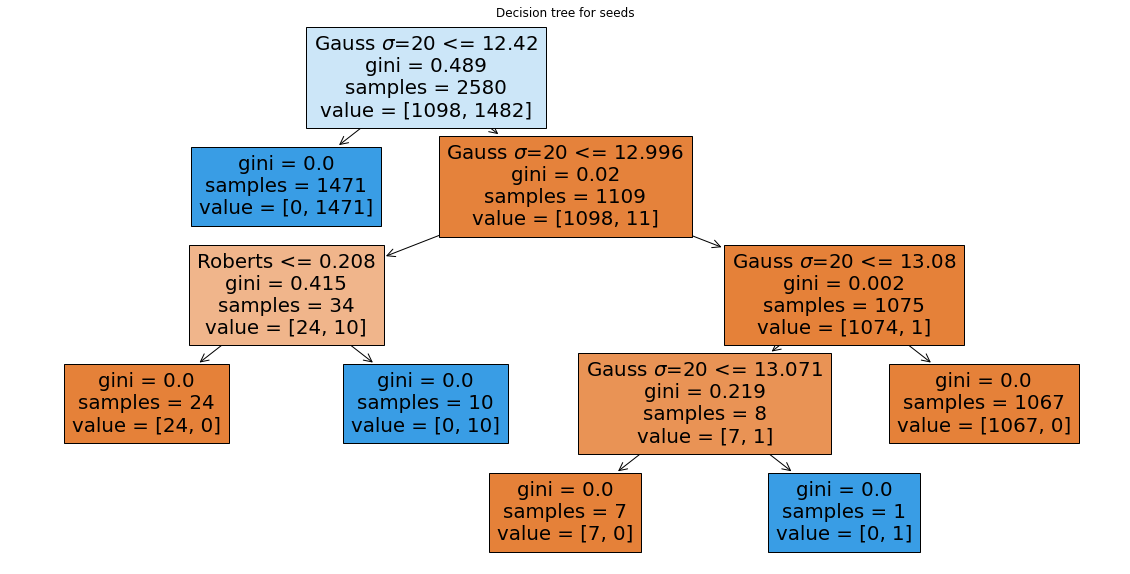

In [113]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(20,10))
plot_tree(decision_tree, filled=True, ax=ax, feature_names=features.columns)
plt.title("Decision tree for seeds")
plt.show()


## Prediction

Now that the model is trained, we can actually use it to do predictions. Let's gather this time *all* our pixels and pass them through the classifier. Here we take all pixels so we just ```ravel``` all filtered images:

In [114]:
all_pixels = np.stack([np.ravel(filt) for filt in all_filt], axis=1)

In [115]:
all_pixels_pd = pd.DataFrame(all_pixels, columns=names)

In [ ]:
predictions = random_forrest.predict(all_pixels_pd)

The output is naturally a long list of pixels that we can *reshape* in the shape of the image:

In [ ]:
predicted_image = np.reshape(predictions, viewer.layers[0].data.shape)

In [ ]:
viewer = napari.Viewer()
viewer.add_image(image)
viewer.add_labels(predicted_image.astype(np.uint8))

In [ ]:
from sklearn.tree import plot_tree

fig, ax = plt.subplots(figsize=(20,10))
plot_tree(tree_clf, filled=True, ax=ax, feature_names=X.columns)
plt.title("Decision tree for seeds")
plt.show()
